In [6]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format = '-', start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [8]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-08-02 10:21:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 2a00:1450:4013:c08::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-08-02 10:21:48 (115 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



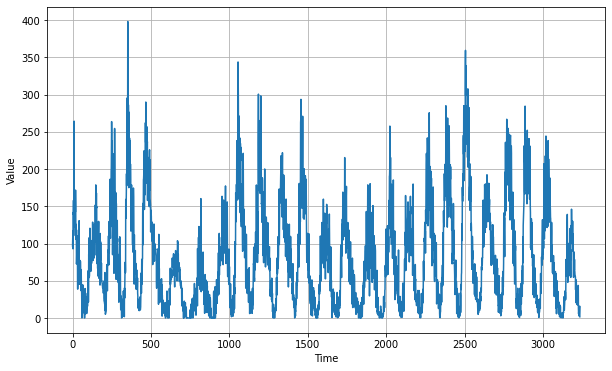

In [9]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

time = np.array(time_step)
series = np.array(sunspots)

plt.figure(figsize = (10,6))
plot_series(time, series)

In [10]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda w : (w[:-1], w[1:]))
  return dataset.batch(batch_size).prefetch(1)

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1,
                             padding = 'causal', activation = 'relu',
                             input_shape = [None,1] ),
      tf.keras.layers.LSTM(64, return_sequences = True),
      tf.keras.layers.LSTM(64, return_sequences = True),
      tf.keras.layers.Dense(30, activation = 'relu'),
      tf.keras.layers.Dense(10, activation  = 'relu'),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x : x*100.0)                        

])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    
    lambda epoch : 1e-8 * 10**(epoch/ 20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

(1e-08, 0.0001, 0.0, 60.0)

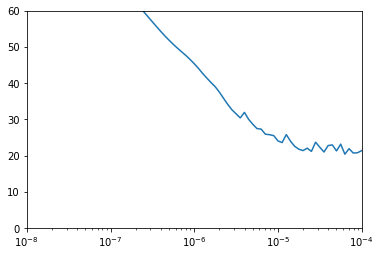

In [12]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 17ms/step - loss: 38.9198 - mae: 39.4161
Epoch 2/500
30/30 [==============================] - 0s 15ms/step - loss: 25.7735 - mae: 26.2680
Epoch 3/500
30/30 [==============================] - 0s 16ms/step - loss: 22.0760 - mae: 22.5697
Epoch 4/500
30/30 [==============================] - 0s 15ms/step - loss: 20.4700 - mae: 20.9630
Epoch 5/500
30/30 [==============================] - 0s 15ms/step - loss: 19.7685 - mae: 20.2609
Epoch 6/500
30/30 [==============================] - 0s 15ms/step - loss: 19.2979 - mae: 19.7901
Epoch 7/500
30/30 [==============================] - 0s 15ms/step - loss: 18.7315 - mae: 19.2236
Epoch 8/500
30/30 [==============================] - 0s 15ms/step - loss: 18.1188 - mae: 18.6104
Epoch 9/500
30/30 [==============================] - 0s 15ms/step - loss: 18.1468 - mae: 18.6385
Epoch 10/500
30/30 [==============================] - 0s 15ms/step - loss: 19.8763 - mae: 20.3686
Epoch 11/500
30/30 [=========

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0]

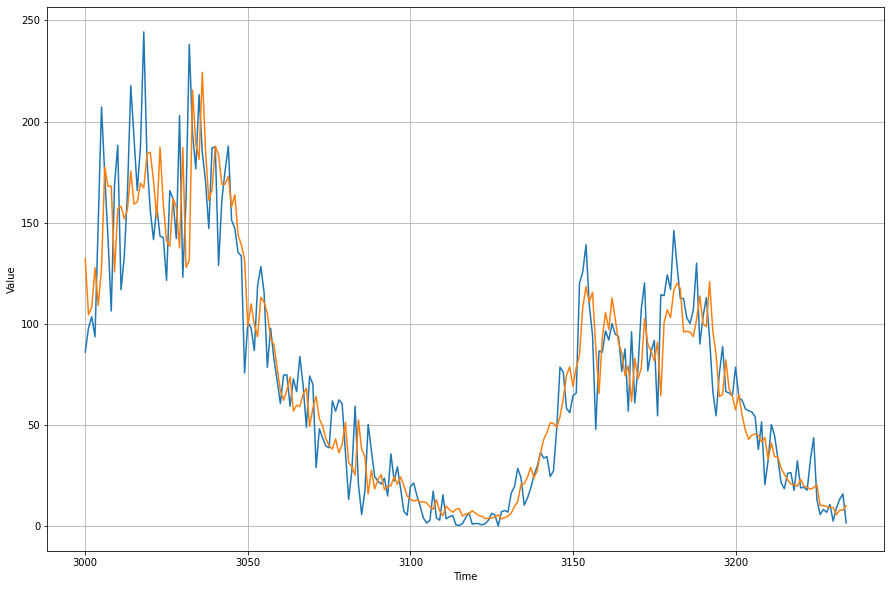

In [20]:
plt.figure(figsize = (15,10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.121393

<Figure size 432x288 with 0 Axes>

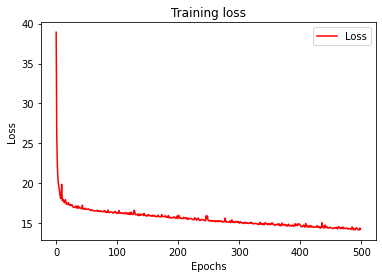

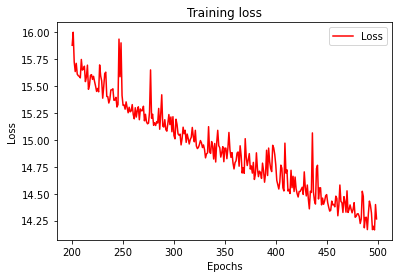

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [23]:
print(rnn_forecast)

[132.10555   104.46322   108.19162   127.685394  109.09513   127.14982
 177.45967   168.01903   167.99431   125.62731   156.81354   158.11624
 151.92322   156.54745   175.54736   159.12846   160.26428   169.55504
 167.19337   183.9859    184.83176   170.6558    152.29929   187.3742
 159.27675   141.0872    138.28778   161.90437   157.83334   137.46896
 187.11676   127.899994  131.3671    215.50975   189.35213   181.28307
 224.30797   185.41202   161.03516   166.44592   187.8839    183.5445
 169.02037   168.96042   172.90244   157.74464   163.76096   143.99744
 138.95367   131.74376    98.753586  109.83948    99.73566    93.5705
 113.0985    110.912254  105.08217    92.85232    89.77746    78.46093
  66.98303    62.209152   67.17292    73.8101     56.875633   59.711163
  59.21296    65.21272    68.21481    49.25799    58.27625    64.108665
  52.95456    49.584476   43.194595   39.80258    38.033474   43.100075
  36.189823   40.211876   51.21827    31.339308   29.277748   25.23384
  52.4